In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-datasets/FPT.csv
/kaggle/input/stock-datasets/VIC.csv
/kaggle/input/stock-datasets/PNJ.csv
/kaggle/input/stock-datasets/MSN.csv


# Bước 1: Import thư viện

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Bước 2: Chuẩn bị dữ liệu

In [4]:
fpt_df = pd.read_csv('/kaggle/input/stock-datasets/FPT.csv')

fpt_df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [5]:
fpt_df = fpt_df[['Date/Time', 'Close']]

/tmp/ipykernel_26/2986356877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpt_df['Date/Time'] = pd.to_datetime(fpt_df['Date/Time'])


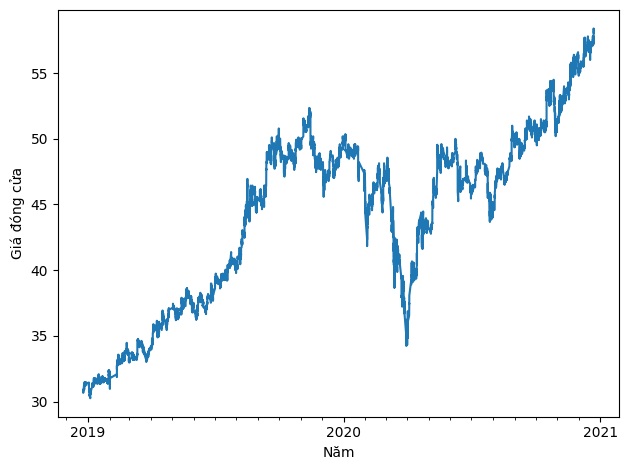

In [6]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

fpt_df['Date/Time'] = pd.to_datetime(fpt_df['Date/Time'])

plt.plot(fpt_df['Date/Time'], fpt_df['Close'])
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator() 
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date/Time', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(fpt_df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date/Time,,,,,,,,
2018-12-26 09:15:00,31.11,30.66,30.74,30.74,30.74,30.74,30.81,30.89
2018-12-26 09:16:00,31.19,31.11,30.66,30.74,30.74,30.74,30.74,30.81
2018-12-26 09:17:00,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74
2018-12-26 09:18:00,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74
2018-12-26 09:19:00,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74
...,...,...,...,...,...,...,...,...
2020-12-22 14:24:00,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10
2020-12-22 14:25:00,58.20,58.20,58.20,58.10,58.10,58.10,58.10,58.10
2020-12-22 14:26:00,58.20,58.20,58.20,58.20,58.10,58.10,58.10,58.10


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))


shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[-0.93889876, -0.97087034, -0.9651865 , ..., -0.9651865 ,
        -0.96021314, -0.95452931],
       [-0.93321492, -0.93889876, -0.97087034, ..., -0.9651865 ,
        -0.9651865 , -0.96021314],
       [-0.93321492, -0.93321492, -0.93889876, ..., -0.9651865 ,
        -0.9651865 , -0.9651865 ],
       ...,
       [ 0.98579041,  0.98579041,  0.98579041, ...,  0.97868561,
         0.97868561,  0.97868561],
       [ 0.97868561,  0.98579041,  0.98579041, ...,  0.97868561,
         0.97868561,  0.97868561],
       [ 0.97868561,  0.97868561,  0.98579041, ...,  0.98579041,
         0.97868561,  0.97868561]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((97399, 7), (97399,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.95452931, -0.96021314, -0.9651865 , ..., -0.9651865 ,
        -0.9651865 , -0.97087034],
       [-0.96021314, -0.9651865 , -0.9651865 , ..., -0.9651865 ,
        -0.97087034, -0.93889876],
       [-0.9651865 , -0.9651865 , -0.9651865 , ..., -0.97087034,
        -0.93889876, -0.93321492],
       ...,
       [ 0.97868561,  0.97868561,  0.97868561, ...,  0.98579041,
         0.98579041,  0.98579041],
       [ 0.97868561,  0.97868561,  0.97868561, ...,  0.98579041,
         0.98579041,  0.98579041],
       [ 0.97868561,  0.97868561,  0.98579041, ...,  0.98579041,
         0.98579041,  0.97868561]])

In [11]:
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77919, 7), (19480, 7), (77919,), (19480,))

In [12]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77919, 7, 1), (19480, 7, 1), (77919, 1), (19480, 1))

In [13]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([77919, 7, 1]),
 torch.Size([19480, 7, 1]),
 torch.Size([77919, 1]),
 torch.Size([19480, 1]))

In [14]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Bước 3: Xây dựng và huấn luyện mô hình

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers #là số lượng tầng LSTM được xếp chồng lên nhau

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    avg_loss_across_batches = running_loss / len(train_loader)
    print(f"Loss: {avg_loss_across_batches}")

In [18]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print(f'Val Loss: {avg_loss_across_batches}')

In [19]:
learning_rate = 0.01
num_epochs = 40
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Loss: 0.000776910305515723
Val Loss: 0.00027417672462324216
Epoch: 2
Loss: 3.8969222091266655e-05
Val Loss: 0.0002713937134049573
Epoch: 3
Loss: 3.57833785792807e-05
Val Loss: 0.00026463411890642114
Epoch: 4
Loss: 3.406865101223546e-05
Val Loss: 0.00020009488434077945
Epoch: 5
Loss: 3.3303179840005236e-05
Val Loss: 0.001029283337967263
Epoch: 6
Loss: 3.2171606982173786e-05
Val Loss: 0.00034953140348263607
Epoch: 7
Loss: 3.1840698010197805e-05
Val Loss: 0.0005837634998778083
Epoch: 8
Loss: 3.0276478957357522e-05
Val Loss: 0.0010586077517221579
Epoch: 9
Loss: 3.034079311251112e-05
Val Loss: 0.0015019584592016004
Epoch: 10
Loss: 2.8943821134936028e-05
Val Loss: 0.0006803166258779871
Epoch: 11
Loss: 2.8235243890632672e-05
Val Loss: 0.0012515994494601609
Epoch: 12
Loss: 2.7876410900554544e-05
Val Loss: 0.00098906804614731
Epoch: 13
Loss: 2.8206128470689918e-05
Val Loss: 0.0005404774520196839
Epoch: 14
Loss: 2.7482270950823612e-05
Val Loss: 0.0005160581191982297
Epoch: 15
Loss: 2.82

# Bước 4: Thực hiện đánh giá trên tập test

In [20]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([48.08267879, 48.08634368, 48.08670023, ..., 58.16033798,
       58.17132971, 58.1460593 ])

In [21]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([48.09999987, 48.09999987, 48.15      , ..., 58.20000032,
       58.10000007, 58.10000007])

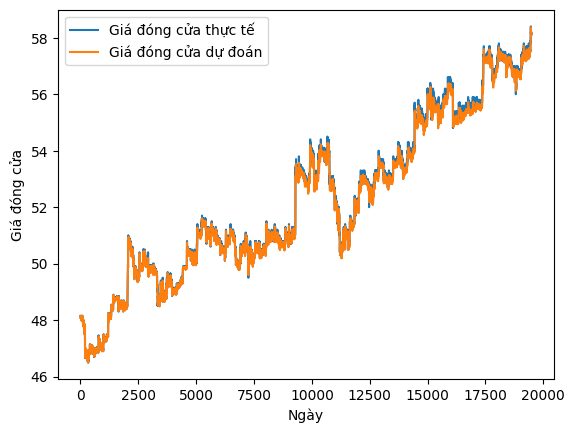

In [22]:
plt.plot(new_y_test, label='Giá đóng cửa thực tế')
plt.plot(test_predictions, label='Giá đóng cửa dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()


In [23]:
pred_fluctuations = []
for i in range(len(test_predictions)-1):
    hieu = test_predictions[i+1] - test_predictions[i]
    pred_fluctuations.append(hieu)
    
actual_fluctuations = []
for i in range(len(new_y_test)-1):
    hieu = new_y_test[i+1] - new_y_test[i]
    actual_fluctuations.append(hieu)

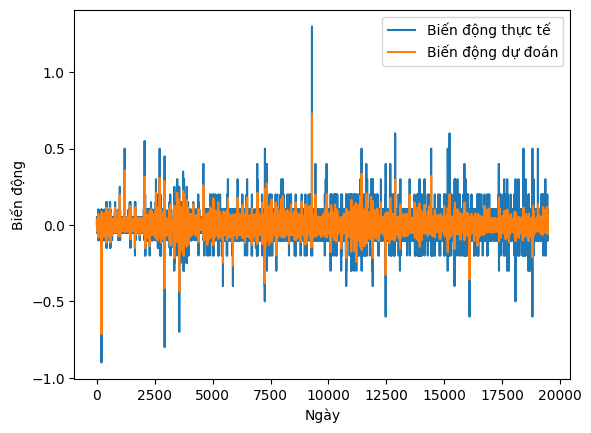

In [24]:
plt.plot(actual_fluctuations, label='Biến động thực tế')
plt.plot(pred_fluctuations, label='Biến động dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Biến động')
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

print('Đánh giá độ chính xác của close price')
print('***************************')
#r2
print('Độ phù hợp tập test:',r2_score(new_y_test,test_predictions))
#mae
print('Sai số tuyệt đối trung bình trên tập test:',mean_absolute_error(new_y_test, test_predictions))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(new_y_test,test_predictions))




Đánh giá độ chính xác của close price
***************************
Độ phù hợp tập test: 0.9984919912493386
Sai số tuyệt đối trung bình trên tập test: 0.08552334497292642
Phần trăm sai số tuyệt đối trung bình tập test: 0.0016024879039680327
